In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
! git clone https://github.com/HoangDuonng1359/Chest-X-Ray.git

Cloning into 'Chest-X-Ray'...
remote: Enumerating objects: 7652, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 7652 (delta 0), reused 99 (delta 0), pack-reused 7551 (from 2)
Receiving objects: 100% (7652/7652), 2.91 GiB | 62.47 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Updating files: 100% (2632/2632), done.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import os
from PIL import Image
from typing import Tuple
from tqdm.auto import tqdm, trange
import torchvision.transforms.functional as f


In [4]:
train_df = pd.read_csv("Chest-X-Ray/data/train_effusion.csv")
valid_df = pd.read_csv("Chest-X-Ray/data/val_effusion.csv")
test_df = pd.read_csv("Chest-X-Ray/data/test_effusion.csv")

train_df.head()

,id,Effusion
0,00010718_010.png,0
1,00011153_000.png,0
2,00007880_000.png,0
3,00011301_000.png,0
4,00029109_000.png,0


In [5]:
class ChestXrayBinaryDataset(Dataset):
    def __init__(self, df, image_dir, label_name, transform=None):
        """
        df: DataFrame chứa thông tin ảnh và nhãn
        image_dir: Thư mục chứa ảnh
        label_name: Tên của nhãn cần phân loại 
        transform: Các phép biến đổi ảnh 
        """
        self.df = df
        self.image_dir = image_dir
        self.label_name = label_name
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = f"{self.image_dir}/{self.df.iloc[idx]['id']}"
        image = Image.open(image_path).convert("RGB")
        label = torch.tensor(
            self.df.iloc[idx][self.label_name], dtype=torch.float32
        )
        if self.transform:
            image = self.transform(image)

        return image, label


In [6]:
import random
class RandomBottomCrop(object):
    def __init__(self, crop_height_ratio=0.5):
        self.crop_height_ratio = crop_height_ratio

    def __call__(self, img):
        w, h = img.size
        crop_h = int(h * self.crop_height_ratio)
        max_start = h - crop_h
        start_y = random.randint(max_start - crop_h//3, max_start)
        return img.crop((0, start_y, w, start_y + crop_h))

In [7]:
transform_train = transforms.Compose([
    RandomBottomCrop(crop_height_ratio=0.5),  
    transforms.Resize((320, 320)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [8]:
transform = transforms.Compose([
    RandomBottomCrop(crop_height_ratio=0.5),
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


train_dataset = ChestXrayBinaryDataset(train_df, 'Chest-X-Ray/data/images','Effusion', transform_train)
valid_dataset = ChestXrayBinaryDataset(valid_df, 'Chest-X-Ray/data/images','Effusion', transform)
test_dataset =  ChestXrayBinaryDataset(test_df, 'Chest-X-Ray/data/images','Effusion', transform)

In [9]:
class Bottleneck(nn.Module):
    expansion = 4  # output_channels = out_channels * 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.downsample = downsample 

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)
        return out

class ResNet50(nn.Module):
    def __init__(self, num_classes=1):  
        super(ResNet50, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(Bottleneck, 64, blocks=3)
        self.layer2 = self._make_layer(Bottleneck, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, blocks=6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x) 
        x = torch.sigmoid(x)
        return x

In [10]:
def evaluate(net: nn.Module, data) -> float:
    """
    Evaluates the neural network on the given data.
    @param net: the neural network to evaluate
    @param data: the data to evaluate on
    @return: the accuracy of the neural network on the given data
    """
    data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=False)

    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).float().unsqueeze(1)  
            outputs = net(inputs)
            pred_target = (outputs > 0.5).float() 
            correct += (pred_target == targets).sum().item()
            total += targets.size(0)

    return correct / total


In [11]:
def train(train_data,
          val_data,
          test_dataset,
          net,
          patience=10,
          **kwargs) -> Tuple[nn.Module, list[float], list[float], list[float], list[float]]:

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)

    net.to(device)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=kwargs['batch_size'], shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=kwargs['batch_size'], shuffle=False)

    optimizer = torch.optim.Adam(net.parameters(), lr=kwargs['lr'], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kwargs['epochs'])


    criterion = torch.nn.BCELoss()

    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    pbar = trange(kwargs['epochs'])
    for epoch in pbar:
        net.train()
        running_loss = 0.0

        for inputs, targets in tqdm(train_loader, leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            running_loss += loss.item()

        scheduler.step()

        train_accuracy = evaluate(net, train_data)
        train_accuracies.append(train_accuracy)

        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device).float().unsqueeze(1)
                outputs = net(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_accuracy = evaluate(net, val_data)
        test_accuracy = evaluate(net, test_dataset)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = net.module.state_dict() if isinstance(net, nn.DataParallel) else net.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        print(
            f"Epoch {epoch+1} | TrainLoss: {running_loss/len(train_loader):.4f} | "
            f"TrainAcc: {train_accuracy:.4f} | ValLoss: {val_loss:.4f} | ValAcc: {val_accuracy:.4f} | TestAcc: {test_accuracy:.4f}"
        )

    if best_model_state is not None:
        if isinstance(net, nn.DataParallel):
            net.module.load_state_dict(best_model_state)
        else:
            net.load_state_dict(best_model_state)

    return net, train_losses, train_accuracies, val_losses, val_accuracies

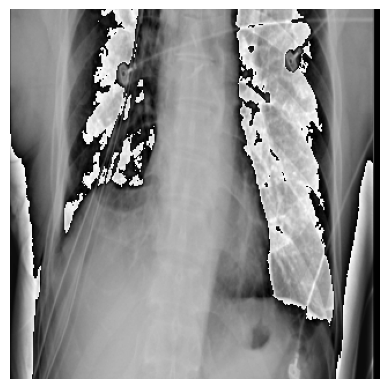

tensor(1.)


In [12]:
# Lấy ảnh và nhãn đầu tiên từ dataset
image, label = test_dataset[9]

# chuyển sang numpy và đưa về [H,W,C]
if isinstance(image, torch.Tensor):
    image = f.to_pil_image(image)
plt.imshow(image) 
plt.axis("off")
plt.show()
print(label)

In [ ]:
print('Start train....')
net = ResNet50()
lr = 5e-4
batch_size = 32
epochs = 100
net, train_losses, train_accuracies, val_losses, val_accuracies = train(train_data=train_dataset,
                                            val_data=valid_dataset,
                                            test_dataset=test_dataset,
                                            net=net,
                                            lr=lr,
                                            optimizer='adam',
                                            batch_size=batch_size,
                                            epochs=epochs, loss_customs = False)

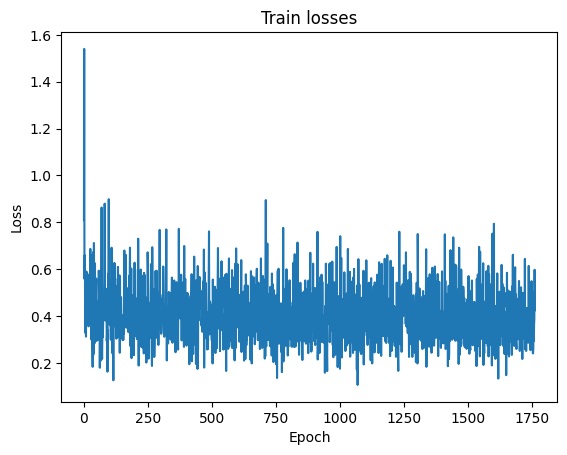

In [14]:
plt.plot(train_losses)
plt.title('Train losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

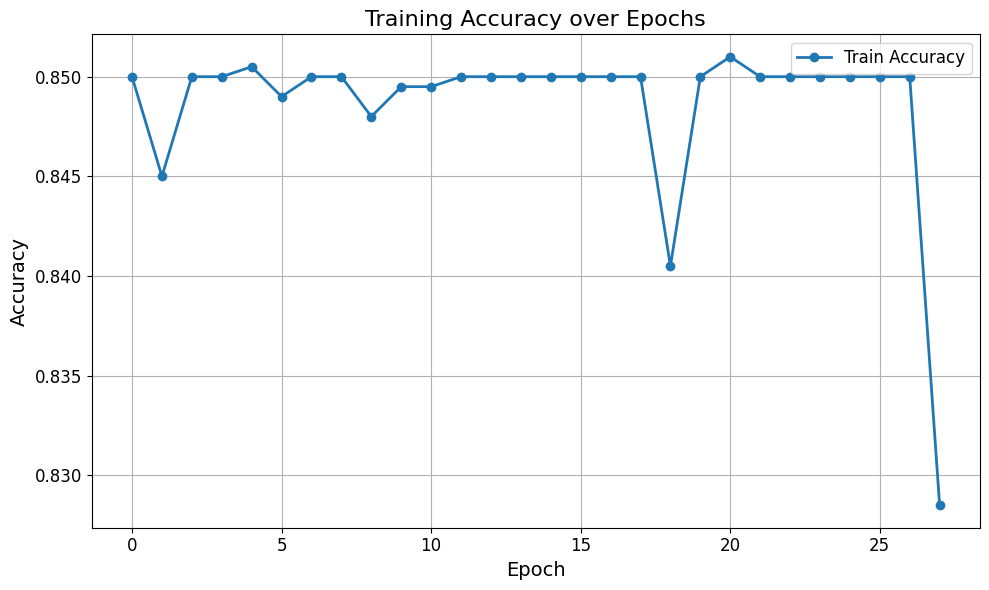

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy', color='tab:blue', linewidth=2, marker='o')

plt.title('Training Accuracy over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

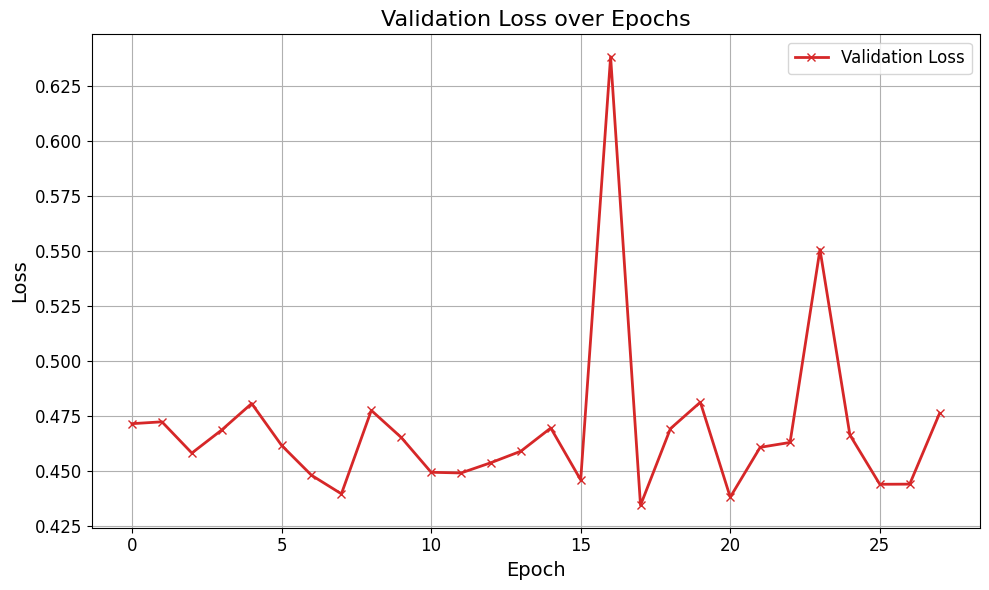

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(val_losses, label='Validation Loss', color='tab:red', linewidth=2, marker='x')

plt.title('Validation Loss over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

In [17]:
print(evaluate(net, test_dataset))

0.7967741935483871


In [18]:
torch.save(net, './model_Effusion_bceLoss.pth')

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def get_probs_and_labels(model, dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
    model.eval()
    probs = []
    labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            probs.extend(out.cpu().numpy().flatten())
            labels.extend(y.cpu().numpy().flatten())
    return np.array(probs), np.array(labels)
probs1, labels1 = get_probs_and_labels(net, test_dataset)
fpr1, tpr1, _ = roc_curve(labels1, probs1)
auc1 = auc(fpr1, tpr1)

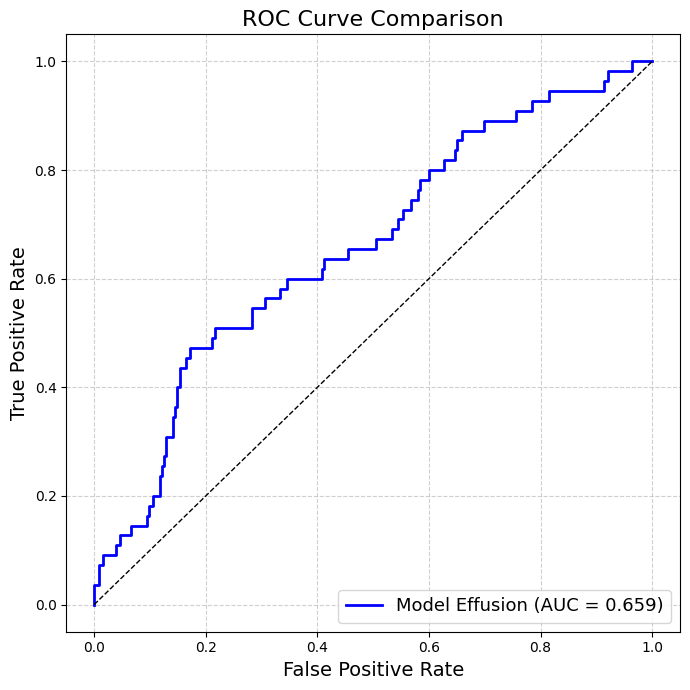

In [20]:
plt.figure(figsize=(7,7))
plt.plot(fpr1, tpr1, color='blue', linewidth=2, label=f'Model Effusion (AUC = {auc1:.3f})')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve Comparison', fontsize=16)
plt.legend(fontsize=13, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()